# ARIMA-SARIMAX
- Data Source: [Monthly fuel consumption in Spain](https://raw.githubusercontent.com/JoaquinAmatRodrigo/Estadistica-machine-learning-python/master/data/consumos-combustibles-mensual.csv)
- Tutorial: [ARIMA and SARIMAX models with Python](https://cienciadedatos.net/documentos/py51-arima-sarimax-models-python.html?fbclid=IwAR1Ex6o8zhlrQFXAbrfWvBu5c563JZVC8HBmPiGoNtO5xzcQOhQqQgiOCJY)

In [3]:
# Libraries
# ======================================================================================
import numpy as np
import pandas as pd
from io import StringIO
import contextlib
import re
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-darkgrid')

# pmdarima
from pmdarima import ARIMA
from pmdarima import auto_arima

# statsmodels
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

# skforecast
from skforecast.Sarimax import Sarimax
from skforecast.ForecasterSarimax import ForecasterSarimax
from skforecast.model_selection_sarimax import backtesting_sarimax
from skforecast.model_selection_sarimax import grid_search_sarimax
from sklearn.metrics import mean_absolute_error

import warnings
warnings.filterwarnings("ignore")

In [4]:
df = pd.read_csv('../data/consumos-combustibles-mensual.csv', index_col='Fecha', parse_dates=['Fecha'])\
       .rename(columns={'Gasolinas':'litters'})['litters']
df.index.name = 'date' # rename index col 'Fecha' to 'date'
df = df.loc[:'1990-01-01']

In [5]:
df.index.max()

Timestamp('1990-01-01 00:00:00')

In [6]:
df = df.asfreq('MS') # downsample to only month start

In [7]:
df.head()

date
1969-01-01    166875.2129
1969-02-01    155466.8105
1969-03-01    184983.6699
1969-04-01    202319.8164
1969-05-01    206259.1523
Freq: MS, Name: litters, dtype: float64

In [8]:
# Train-test dates
# ======================================================================================
end_train = '1980-01-01 23:59:59'
print(f"Train dates : {df.index.min()} --- {df.loc[:end_train].index.max()}  (n={len(df.loc[:end_train])})")
print(f"Test dates  : {df.loc[end_train:].index.min()} --- {df.loc[:].index.max()}  (n={len(df.loc[end_train:])})")
data_train = df.loc[:end_train]
data_test  = df.loc[end_train:]

Train dates : 1969-01-01 00:00:00 --- 1980-01-01 00:00:00  (n=133)
Test dates  : 1980-02-01 00:00:00 --- 1990-01-01 00:00:00  (n=120)


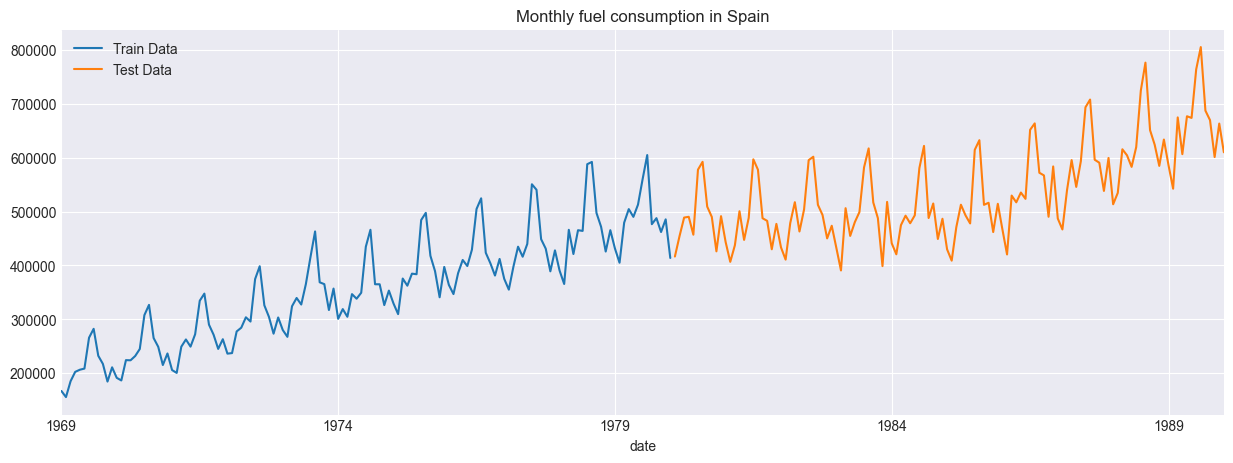

In [9]:
fig, ax = plt.subplots(figsize=(15,5))
data_train.plot(ax=ax, label='Train Data')
data_test.plot(ax=ax, label='Test Data')
ax.legend()
ax.set_title('Monthly fuel consumption in Spain')
plt.show()

In [11]:
data_train.head()

date
1969-01-01    166875.2129
1969-02-01    155466.8105
1969-03-01    184983.6699
1969-04-01    202319.8164
1969-05-01    206259.1523
Freq: MS, Name: litters, dtype: float64

In [15]:
data_diff_1 = data_train.diff().dropna()
data_diff_2 = data_diff_1.diff().dropna()

In [16]:
def test_stationary(df):
    adfuller_result = adfuller(df)
    kpss_result = kpss(df)
    print(f'ADF Statistic : {adfuller_result[0]}, p-value: {adfuller_result[1]}')
    print(f'KPSS Statistic: {kpss_result[0]}, p-value: {kpss_result[1]}')

In [21]:
print('\nTest stationarity for original series')
print('-------------------------------------')
test_stationary(df)


Test stationarity for original series
-------------------------------------
ADF Statistic : -0.44612980998227814, p-value: 0.9021071923942668
KPSS Statistic: 2.2096370946978383, p-value: 0.01


- For ADF test: Since the `p-value=0.09 > 0.05`, so cant reject the null hypothesis (the data is non-stationary) 
- For KPSS test: Since the `p-value=0.01 < 0.05`, so can reject the null hypothesis (the data is stationary) 

In [22]:
print('\nTest stationarity for differenced series (order=1)')
print('-------------------------------------')
test_stationary(data_diff_1)

print('\nTest stationarity for differenced series (order=2)')
print('-------------------------------------')
test_stationary(data_diff_2)


Test stationarity for differenced series (order=1)
-------------------------------------
ADF Statistic : -3.6417276900323285, p-value: 0.005011605002137147
KPSS Statistic: 0.05268059379842924, p-value: 0.1

Test stationarity for differenced series (order=2)
-------------------------------------
ADF Statistic : -8.23394264165606, p-value: 5.959599575494087e-13
KPSS Statistic: 0.49999999999998757, p-value: 0.04166666666666947


- After the first differencing, the time series is indeed stationary. - Therefore, the most appropriate selection for the ARIMA parameter  $𝑑=1$.

